## Group_Food 

In [1]:
%%capture 
!pip install ampligraph

In [2]:

import numpy as np
import pandas as pd
import ampligraph

ampligraph.__version__

'1.4.0'

# Data prep

In [3]:
df = pd.read_csv('Databased.csv')
df = df.rename(columns = {'title': 'Foods', 'NER': 'Ingredients'}, inplace = False)
df = df[:1000] # use 1000 row 
df.head()

,Foods,Ingredients
0,No-Bake Nut Cookies,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [4]:
print(type(df.Ingredients))

<class 'pandas.core.series.Series'>


In [5]:
df.isna().sum()

Foods          0
Ingredients    0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
row_list = []

for i in range(len(df)):
    txt = df.Ingredients[i]
    txt = txt.strip('[]')
    txt = txt.strip('\"')
    txt = txt.split('\", "')

    name = df.Foods[i].strip(' ')

    for k in txt:

        dict1 = {'FOOD':  name, 'SUBJECT':  name, 'RELATION': 'HasIngredients', 'OBJECT': k}
        row_list.append(dict1)

# Create the new df
df_food = pd.DataFrame(row_list)

In [8]:
df_food

,FOOD,SUBJECT,RELATION,OBJECT
0,No-Bake Nut Cookies,No-Bake Nut Cookies,HasIngredients,brown sugar
1,No-Bake Nut Cookies,No-Bake Nut Cookies,HasIngredients,milk
2,No-Bake Nut Cookies,No-Bake Nut Cookies,HasIngredients,vanilla
3,No-Bake Nut Cookies,No-Bake Nut Cookies,HasIngredients,nuts
4,No-Bake Nut Cookies,No-Bake Nut Cookies,HasIngredients,butter
...,...,...,...,...
7303,Peach Salad,Peach Salad,HasIngredients,Condensed Milk
7304,Peach Salad,Peach Salad,HasIngredients,cream cheese
7305,Peach Salad,Peach Salad,HasIngredients,hot water
7306,Peach Salad,Peach Salad,HasIngredients,sugar


# Sample Graph

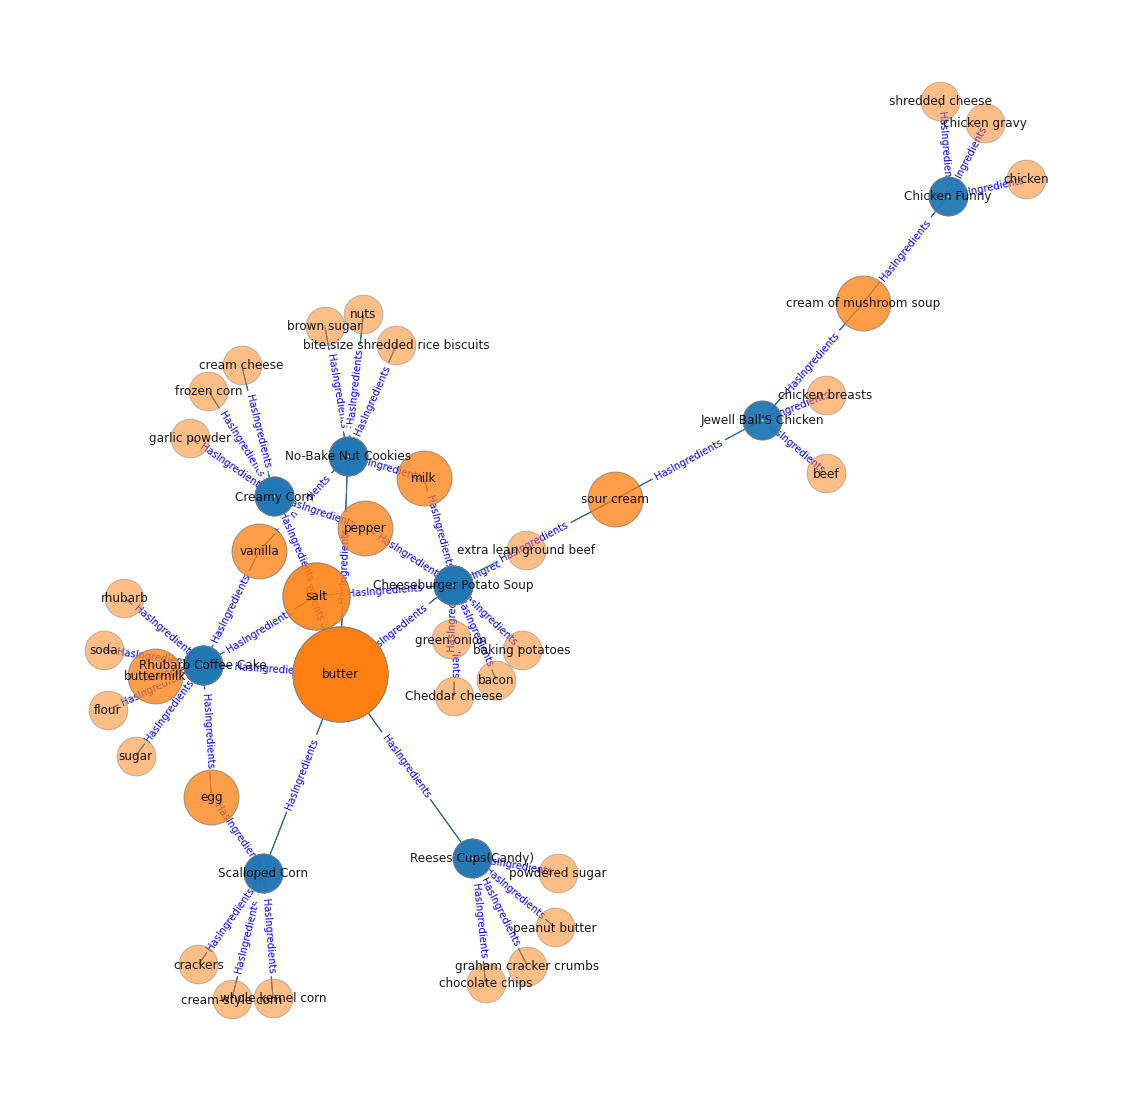

In [9]:
# Make the graph
# Graph Plotting tools
import networkx             as nx
import seaborn              as sns
import matplotlib.pyplot    as plt
from collections import Counter
%matplotlib inline

g = nx.MultiGraph()

dfg = df_food[:50]

weight_list = list(dfg.SUBJECT) +  list(dfg.OBJECT)
weight_nodes = Counter(weight_list)

# ------------------------------------------------------------------------------

for   i in range(len(dfg)):
      g.add_edges_from([(dfg.SUBJECT[i],    dfg.OBJECT[i])])

pos = nx.spring_layout(g, seed=32)
plt.figure(figsize=(20,20))

# nodes
options = {"edgecolors": "tab:gray", "alpha": 0.5,}

nx.draw_networkx_nodes(g, pos, nodelist= list(dfg.FOOD), node_size=1500, node_color = "tab:blue", **options)   # Draw Topic

# ------------------------------------------------------------------------------

nx.draw(g, pos,edge_color='black', node_size=1,node_color='white',alpha=0.9 , labels={node:node for node in g.nodes()})

for  i in range(len(dfg)):
      if  dfg.RELATION[i] == 'NumOfIngredients':
          nx.draw_networkx_nodes(g, pos, node_size = weight_nodes[dfg.OBJECT[i]]*1500, nodelist= [dfg.OBJECT[i]],   node_color= "tab:green", **options)
          nx.draw_networkx_edges(g, pos, edgelist = [(dfg.SUBJECT[i],   dfg.OBJECT[i])],  edge_color = "tab:green")
          nx.draw_networkx_edge_labels(g, pos, edge_labels={(dfg.SUBJECT[i],   dfg.OBJECT[i]) :   dfg.RELATION[i]},    font_color='green')
      
      if  dfg.OBJECT[i] not in  list(dfg.FOOD) and  dfg.RELATION[i] != 'NumOfIngredients':
          nx.draw_networkx_nodes(g, pos, node_size = weight_nodes[dfg.OBJECT[i]]*1500, nodelist= [dfg.OBJECT[i]],   node_color= "tab:orange", **options)
          nx.draw_networkx_edges(g, pos, edgelist = [(dfg.SUBJECT[i],   dfg.OBJECT[i])],  edge_color = "tab:blue")
          nx.draw_networkx_edge_labels(g, pos, edge_labels={(dfg.SUBJECT[i],   dfg.OBJECT[i]) :   dfg.RELATION[i]},    font_color='blue')

plt.show()

# Similarity

In [11]:
G = nx.MultiGraph() # Use all data point

for   i in range(len(df_food)):
      G.add_edges_from([(df_food.SUBJECT[i],    df_food.OBJECT[i])])

In [12]:
recommend = nx.simrank_similarity(G , 'No-Bake Nut Cookies')
df_recommend = pd.DataFrame.from_dict({k: v for k, v in sorted(recommend.items(), key=lambda item: item[1], reverse=True)}, orient='index', columns=['Score'])

In [13]:
df_recommend.head(10)

,Score
No-Bake Nut Cookies,1.000000
Low Cholesterol Ice Cream,0.158353
Chocolate Icing,0.154444
Easy Chocolate Frosting,0.153825
Vanilla Ice Cream,0.152475
Foolproof Fudge,0.151835
Preacher Cookies,0.142916
Breakfast Rolls,0.141533
Toffee Brickle,0.140127
Golf Balls,0.139087


In [14]:
import operator

personalization   ={"No-Bake Nut Cookies": 1, "Irish Stew(Microwave)": 1, "Creamy CornReeses Cups(Candy)": 1,"Rhubarb Coffee Cake": 1, "Millionaire Pie": 1}
dangling            = {'Chicken Funny': 1, 'Cheeseburger Potato Soup': 1, 'Scalloped Corn': 1}

ppr = nx.pagerank(G, personalization = personalization, alpha=0.7 , dangling = dangling)
ppr = sorted(ppr.items(), key=operator.itemgetter(1), reverse=True)

In [15]:
row_list = []

for   item, score in ppr:
       if   item in set(df_food.FOOD) and item not in personalization:
            dict1 = {'Food':  item, 'SCORE':  score}
            row_list.append(dict1)

# Create the new df
recom_ppr_food= pd.DataFrame(row_list)
recom_ppr_food.head(10)

,Food,SCORE
0,Dick'S Grilled Boneless Leg Of Lamb,0.003538
1,Blueberry Heaven Supreme,0.003369
2,Caramel Pie,0.003232
3,Pretty Party Punch,0.003206
4,Devils Chicken(Pollo Alla Diavola),0.002602
5,Lemon Chicken,0.002325
6,Chicken Casserole,0.002136
7,Vegetable Soup,0.001988
8,Eggplant Spaghetti Sauce,0.001811
9,French Onion Soup,0.001769


In [16]:
row_list = []

for   item, score in ppr:
       if   item not in set(df_food.FOOD):
            dict1 = {'Ingredient':  item, 'SCORE':  score}
            row_list.append(dict1)

# Create the new df
recom_ppr_food= pd.DataFrame(row_list)
recom_ppr_food.head(10)

,Ingredient,SCORE
0,butter,0.021841
1,flour,0.020968
2,vanilla,0.020576
3,sugar,0.016056
4,milk,0.015394
5,salt,0.015113
6,pineapple,0.014371
7,pecans,0.013742
8,condensed milk,0.012930
9,lemons,0.012598


# Train/Test knowledge graph embeddings

In [45]:
from ampligraph.evaluation import train_test_split_no_unseen

df_food_use = df_food[['SUBJECT',	'RELATION',	'OBJECT']]

X_train_, X_unseen  = train_test_split_no_unseen(np.array(df_food_use), test_size = round(len(df_food)*0.005))
X_train, X_valid        = train_test_split_no_unseen(np.array(X_train_), test_size = round(len(df_food)*0.1))

In [46]:
print('Unseen set size    : ', X_unseen.shape)
print('Train set size        : ', X_train.shape)
print('Test set size         : ', X_valid.shape)

Unseen set size    :  (37, 3)
Train set size        :  (6540, 3)
Test set size         :  (731, 3)


In [47]:
from ampligraph.latent_features import ComplEx

model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=888, 
                verbose=True)

In [48]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)

Average ComplEx Loss:   0.285455: 100%|███████████████████████████████████████████| 300/300 [04:36<00:00,  1.08epoch/s]


In [49]:
filter_triples = np.concatenate((X_train, X_valid))

In [50]:
filter_triples

array([['Marinated Onions And Blue Cheese', 'HasIngredients',
        'olive oil'],
       ['Pineapple Mold', 'HasIngredients', 'walnuts'],
       ['Blueberry Cake', 'HasIngredients', 'salt'],
       ...,
       ['Shrimp Batter', 'HasIngredients', 'paprika'],
       ['Apple Sour Cream Coffee Cake', 'HasIngredients', 'sour cream'],
       ['Mexican Bean Salad', 'HasIngredients', 'onion']], dtype=object)

In [51]:
from ampligraph.evaluation import evaluate_performance

ranks = evaluate_performance(X_valid,
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True,
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|███████████████████████████████████████████████████████████████████████████████| 731/731 [00:06<00:00, 113.61it/s]


In [52]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.21
MR: 169.97
Hits@10: 0.33
Hits@3: 0.21
Hits@1: 0.15



## Predicting New Links



In [65]:
X_unseen2 = np.array([['brown sugar', 'HasIngredients', 'Wesson oil'],
                                ['milk', 'HasIngredients', 'black olives'],
                                ['vanilla', 'HasIngredients', 'grated ginger'],
                                ['nuts', 'HasIngredients', 'Worcestershire sauce']])

X_unseen = np.vstack((X_unseen,X_unseen2))
positives_filter = np.array(X_train)

In [66]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

In [67]:
ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 108.24it/s]


In [68]:
scores = model.predict(X_unseen)

In [69]:
from scipy.special import expit
probs = expit(scores)

In [71]:
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))),
             
             columns=['statement', 'rank', 'score', 'probs']).sort_values(["score"], ascending = False )

,statement,rank,score,probs
20,Meat Loaf HasIngredients onion,1,8.541090,0.999805
36,Chicken Casserole HasIngredients eggs,1,8.494292,0.999795
25,Scalloped Corn HasIngredients butter,1,8.481087,0.999793
30,Hungarian Goulash HasIngredients water,1,8.362314,0.999767
23,Rhubarb Coffee Cake HasIngredients flour,7,6.726895,0.998803
26,Chinese Hamburger HasIngredients celery,5,6.721144,0.998796
6,Harvard Beets HasIngredients brown sugar,11,6.021308,0.997579
10,Cherry Wink Cookies HasIngredients flour,29,5.859213,0.997155
22,Brazilian Coffee Cookies HasIngredients baking...,88,5.475055,0.995827
31,Boiled Dressing HasIngredients salt,17,5.456224,0.995749


## Clustering

In [33]:
%%capture
!pip install seaborn adjustText
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!pip install incf.countryutils/.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

%matplotlib inline

In [34]:
foods = df_food.FOOD.unique()

In [35]:
foods

array(['No-Bake Nut Cookies', "Jewell Ball'S Chicken", 'Creamy Corn',
       'Chicken Funny', 'Reeses Cups(Candy)', 'Cheeseburger Potato Soup',
       'Rhubarb Coffee Cake', 'Scalloped Corn', "Nolan'S Pepper Steak",
       'Millionaire Pie', 'Double Cherry Delight', 'Buckeye Candy',
       'Quick Barbecue Wings', 'Taco Salad Chip Dip',
       'Pink Stuff(Frozen Dessert)', 'Fresh Strawberry Pie',
       'Easy German Chocolate Cake', 'Broccoli Salad',
       'Strawberry Whatever', 'Eggless Milkless Applesauce Cake',
       "Grandma Hanrath'S Banana Breadfort Collins, Colorado",
       'Chocolate Frango Mints', 'Cuddy Farms Marinated Turkey',
       'Spaghetti Sauce To Can', 'Prize-Winning Meat Loaf',
       'Smothered Round Steak(Servings: 4)',
       'Corral Barbecued Beef Steak Strips', 'Easy Fudge',
       'Taco-Filled Green Pepper', 'One Hour Rolls',
       'Punch Bowl Fruit Salad', 'Summer Chicken', 'Cherry Pizza',
       'Potato And Cheese Pie', 'Tuna Macaroni Casserole',
       'A

In [36]:
foods_embeddings = dict(zip(foods, model.get_embeddings(foods)))

In [37]:
data = list(foods_embeddings.values())
an_array = np. array(data)
print(an_array)

[[ 0.13476092  0.12860818 -0.125897   ...  0.05468896  0.1517074
   0.1601619 ]
 [-0.12508295  0.18910159  0.15646867 ...  0.12600215  0.17524844
   0.03135253]
 [ 0.06169746 -0.08091754 -0.10486199 ...  0.30114153 -0.12609972
  -0.21414013]
 ...
 [ 0.05276695  0.17669258 -0.23346987 ... -0.02690553 -0.0066411
  -0.12879425]
 [-0.04008022 -0.08421269 -0.11872928 ... -0.24351344 -0.10113888
   0.05213027]
 [ 0.11042237  0.21299236  0.06474017 ... -0.08119759 -0.18850555
  -0.15612452]]


We use PCA to project the embeddings into 2D space:

In [38]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in foods_embeddings.values()]))

In [39]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=4, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(foods, model, clustering_algorithm, mode='entity')

Text(0, 0.5, 'WCSS')

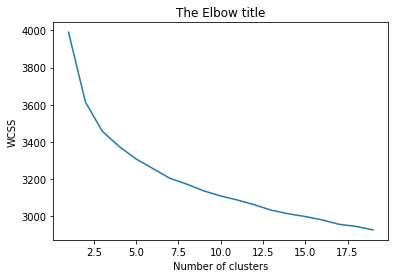

In [40]:
wcss=[]
max_k = 20
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(an_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [41]:
plot_df = pd.DataFrame({"foods": foods, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "continent": pd.Series(foods),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [42]:
top20menu = ['No-Bake Nut Cookies', "Jewell Ball'S Chicken", 'Creamy Corn',
       'Chicken Funny', 'Reeses Cups(Candy)', 'Cheeseburger Potato Soup',
       'Rhubarb Coffee Cake', 'Scalloped Corn', "Nolan'S Pepper Steak"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.continent !="unk"], x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["foods"] in top20menu or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["foods"])))
    adjust_text(texts)

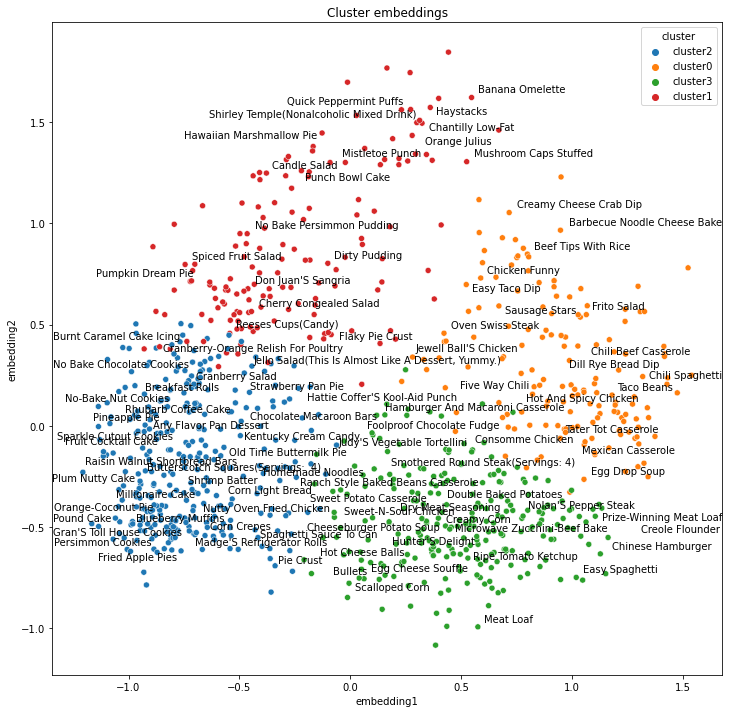

In [44]:
plot_clusters("cluster")